## This Model was used to Generate the Level Sets

In [1]:
# make pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable as Var

# make relevant imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=24)
plt.rc('font', family='serif')
plt.rc('font', family='serif')

In [2]:
# define a general NN

class NN(nn.Module):

  def __init__(self, inp=3, outp=3):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(inp, 20) # fully connected layers
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 20)
    self.fc4 = nn.Linear(20, 20)
    self.fc5 = nn.Linear(20, outp)

  def forward(self, x):
    if x.requires_grad==False:
      x.requires_grad==True  # keep track of gradient wrt input

    y = torch.tanh(self.fc1(x))
    y = torch.tanh(self.fc2(y))
    y = torch.tanh(self.fc3(y))
    y = torch.tanh(self.fc4(y))
    y = (self.fc5(y))

    return y

In [3]:
# Define Neural Networks

encoder2 = NN(inp=3, outp=3)    # maps original coordinates to encoding
decoder2 = NN(inp=3, outp=3)    # maps encoding back to original coordinates
estimator2 = NN(inp=1, outp=3)  # estimates the target functions

In [4]:
# read in data with pandas
# convert to numpy and torch tensors


data = pd.read_csv('Subsystem2_Data_new.csv')


# use only first three functions
f1data = data['t1'].to_numpy()
f2data = data['t2'].to_numpy()
f3data = data['t3'].to_numpy()

print(len(f1data))

f_target = np.zeros([len(f1data), 3])
f_target[:, 0] = f1data
f_target[:, 1] = f2data
f_target[:, 2] = f3data

kf2 = data['kf2'].to_numpy()
kr2 = data['kr2'].to_numpy()
kcat2 = data['kcat2'].to_numpy()

k_parameters = np.zeros([len(kf2),3])
k_parameters[:, 0] = kf2
k_parameters[:, 1] = kr2
k_parameters[:, 2] = kcat2

# normalize
mean_param =  np.mean(k_parameters, axis=0);std_param = np.std(k_parameters, axis=0)
k_parameters = (k_parameters - mean_param)/std_param
f_target = (f_target - np.mean(f_target, axis=0))/np.std(f_target, axis=0)


10000


In [5]:
kf2_mean = np.mean(kf2)
kr2_mean = np.mean(kr2)
kcat_mean = np.mean(kcat2)
keff = kf2*kcat2/(kr2 + kcat2)
print('keff = ', kf2_mean*kcat_mean/(kr2_mean + kcat_mean))

keff =  0.5674272810663895


In [6]:
# define loss criterion and NN Vars:
criterion = nn.MSELoss(reduction='mean')

k_params_in = Var(torch.from_numpy(k_parameters))
k_params_in.requires_grad=True

f_target_out = Var(torch.from_numpy(f_target))
reg_target = torch.zeros(len(f_target))

# set optimizers
optimizer1 = optim.Adam(encoder2.parameters(), lr=0.0001)
optimizer2 = optim.Adam(decoder2.parameters(), lr=0.0001)
optimizer3 = optim.Adam(estimator2.parameters(), lr=0.0001)

In [7]:
###########################################################
# Training All three networks
###########################################################

encoder2.train()
decoder2.train()
estimator2.train()

encoder2.double()
decoder2.double()
estimator2.double()

for time in range(2):
    encoding_pred = encoder2(k_params_in)  # make prediction
    k_params_pred = decoder2(encoding_pred)

    dj1_dk = autograd.grad(encoding_pred[:,0], k_params_in, torch.ones(encoding_pred[:,0].size()), retain_graph=True, allow_unused=True, create_graph=True)[0]
    dj2_dk = autograd.grad(encoding_pred[:,1], k_params_in, torch.ones(encoding_pred[:,0].size()), retain_graph=True, allow_unused=True, create_graph=True)[0]
    dj3_dk = autograd.grad(encoding_pred[:,2], k_params_in, torch.ones(encoding_pred[:,0].size()), retain_graph=True, allow_unused=True, create_graph=True)[0]

    reg1 = torch.mul(dj1_dk, dj2_dk).sum(1)
    reg2 = torch.mul(dj1_dk, dj3_dk).sum(1)
    reg3 = torch.mul(dj2_dk, dj3_dk).sum(1)

    loss1 = criterion(k_params_pred, k_params_in) # compute loss
    loss1 += 33 * criterion(reg1.float(), reg_target.float())
    loss1 += 33 * criterion(reg2.float(), reg_target.float())
    loss1 += 33 * criterion(reg3.float(), reg_target.float())

    # backward pass and update
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    print(loss1)
    loss1.backward(retain_graph=True)
    optimizer1.step()
    optimizer2.step()

    encoding_pred = encoder2(k_params_in)
    f_pred = estimator2(torch.unsqueeze(encoding_pred[:, 0], dim=1))

    loss2 = criterion(f_pred, f_target_out)

    optimizer3.zero_grad()
    optimizer1.zero_grad()
    loss2.backward()
    optimizer3.step()
    optimizer1.step()

    if criterion(k_params_pred, k_params_in).item() < 0.00001:
        break

    if time%20 == 0:
        print('Epoch: {}, Loss1: {}, Regularity: {}, Loss2: {}'.format(time, loss1.item(), criterion(reg1+reg2+reg3, reg_target), loss2.item()))

tensor(1.0073, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch: 0, Loss1: 1.007321684007216, Regularity: 1.6395579320620947e-06, Loss2: 1.0656161232452923
tensor(1.0071, dtype=torch.float64, grad_fn=<AddBackward0>)


### Load The Weights

In [8]:
estimator2 = torch.load('estimator2_larger_sampling2')
encoder2 = torch.load('encoder2_larger_sampling2')
decoder2 = torch.load('decoder2_larger_sampling2')

### Check that the effective coordinate is identified properly (This is not the same model used to show the one-to-one relationship in the paper but still finds something one-to-one)

Text(0, 0.5, '$\\nu_1$')

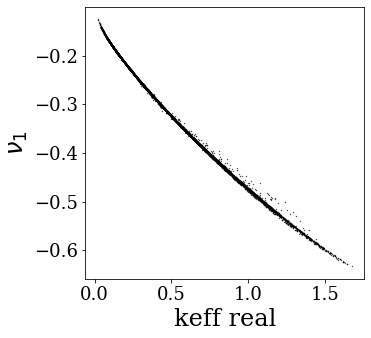

In [9]:
auto_enc_var=encoder2(k_params_in).data.numpy()
fig = plt.figure(figsize=(5,5))
plt.scatter(keff,auto_enc_var[:,0],c='k',s=0.1)
plt.xlabel('keff real')
plt.ylabel(r'$\nu_1$')

### Check that the behavior predictor finds the right thing

In [10]:
encoding_pred = encoder2(k_params_in)
f_pred = estimator2(torch.unsqueeze(encoding_pred[:, 0], dim=1))

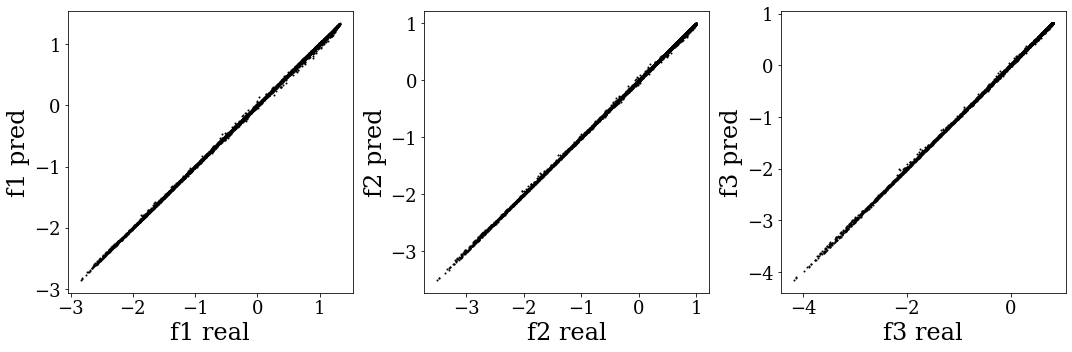

In [11]:
fig = plt.figure(figsize =(15,5))
plt.subplot(1,3,1)
plt.scatter(f_target_out[:,0].data.numpy(),f_pred[:, 0].data.numpy(),s=1,c='k')
plt.xlabel('f1 real');plt.ylabel('f1 pred')


plt.subplot(1,3,2)
plt.scatter(f_target_out[:,1].data.numpy(),f_pred[:, 1].data.numpy(),s=1,c='k')
plt.xlabel('f2 real');plt.ylabel('f2 pred')

plt.subplot(1,3,3)
plt.scatter(f_target_out[:,2].data.numpy(),f_pred[:, 2].data.numpy(),s=1,c='k')
plt.xlabel('f3 real');plt.ylabel('f3 pred')

plt.tight_layout()

### Check the AutoEncoder's reconstruction

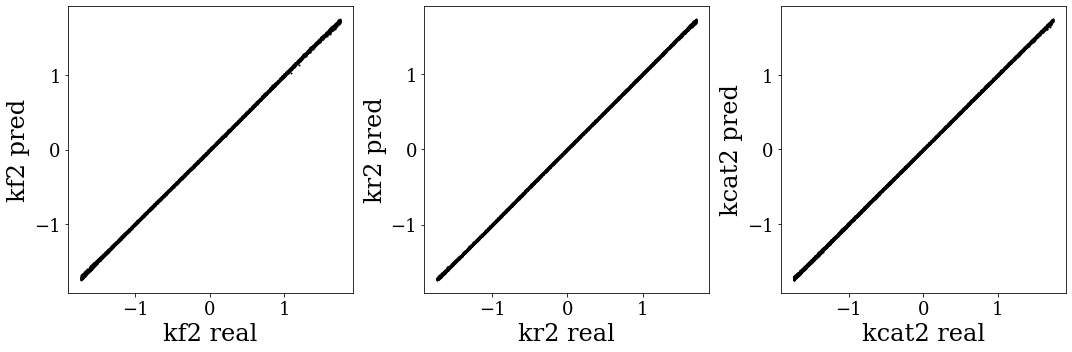

In [12]:
Decoded_Parameters =decoder2(encoder2(k_params_in))

fig = plt.figure(figsize =(15,5))
plt.subplot(1,3,1)
plt.scatter(k_parameters[:,0],Decoded_Parameters[:, 0].data.numpy(),s=1,c='k')
plt.xlabel('kf2 real');plt.ylabel('kf2 pred')


plt.subplot(1,3,2)
plt.scatter(k_parameters[:,1],Decoded_Parameters[:, 1].data.numpy(),s=1,c='k')
plt.xlabel('kr2 real');plt.ylabel('kr2 pred')

plt.subplot(1,3,3)
plt.scatter(k_parameters[:,2],Decoded_Parameters[:, 2].data.numpy(),s=1,c='k')
plt.xlabel('kcat2 real');plt.ylabel('kcat2 pred')

plt.tight_layout()

Text(0, 0.5, 'kf2 pred')

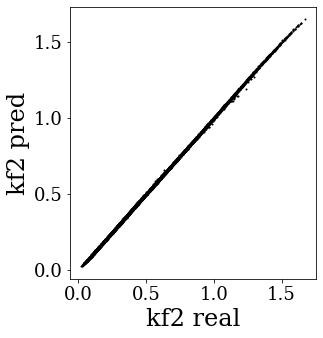

In [13]:
fig = plt.figure(figsize =(15,5))
plt.subplot(1,3,1)
Decoded_Parameters = Decoded_Parameters.data.numpy()*std_param + mean_param
keff_decod = Decoded_Parameters[:, 0]*Decoded_Parameters[:, -1]/(Decoded_Parameters[:, 1]+Decoded_Parameters[:, -1])
keff = kf2*kcat2/(kcat2  + kr2)

plt.scatter(keff,keff_decod,s=1,c='k')
plt.xlabel('kf2 real');plt.ylabel('kf2 pred')


### Generate a random set of Parameters to plot Level Sets

In [14]:
n =200
kcat2_lin,kr2_lin  = np.meshgrid(np.linspace(3000,6500,n),
                                  np.linspace(9000,11000,n))


kcat2_lin = kcat2_lin.reshape(-1,1);
kr2_lin = kr2_lin.reshape(-1,1)


keff  =np.ones_like(kr2_lin).reshape(-1,1)*0.3

kf2_lin =keff/kcat2_lin*(kr2_lin + kcat2_lin)

Parameters = np.c_[kf2_lin,kr2_lin,kcat2_lin]
Parameters =  (Parameters - mean_param)/std_param

Parameters_real  = Parameters*std_param + mean_param

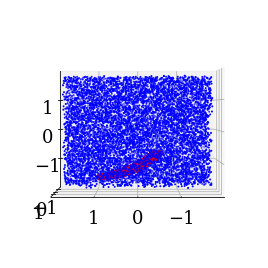

In [15]:
 fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(Parameters[:,0],Parameters[:,1],Parameters[:,2],c='r')
ax.scatter3D(*k_params_in.T.data.numpy() , c= 'b',s=1)
ax.view_init(1, 90);

In [16]:
Param_red = Var(torch.from_numpy(Parameters))
Param_red.requires_grad=True

auto_enc_var_lev_set=encoder2(Param_red).data.numpy()

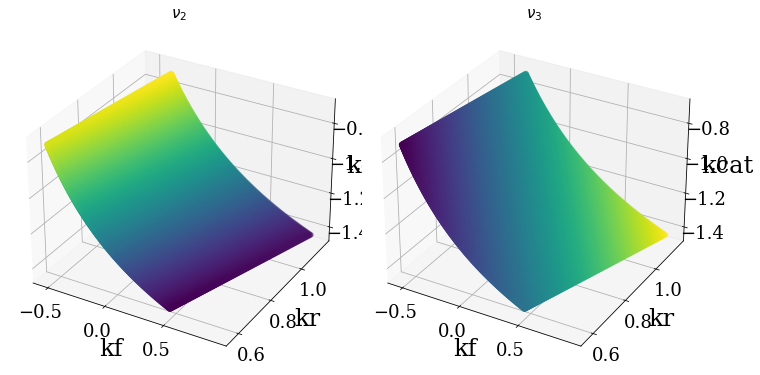

In [17]:
fig = plt.figure(figsize= (10,7.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(Parameters[:,0],Parameters[:,1],Parameters[:,2],c=auto_enc_var_lev_set[:,1])
ax.set_xlabel('kf');ax.set_ylabel('kr');
ax.set_zlabel('kcat');
ax.set_title(r'$\nu_2$',fontsize= 15)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Parameters[:,0],Parameters[:,1],Parameters[:,2],c=auto_enc_var_lev_set[:,2])
ax.set_xlabel('kf');
ax.set_ylabel('kr');ax.set_zlabel('kcat')
ax.set_title(r'$\nu_3$',fontsize= 15)

plt.tight_layout()

In [18]:
xx,yy  = np.meshgrid(np.linspace(np.min(auto_enc_var_lev_set[:,1]),np.max(auto_enc_var_lev_set[:,1],0),n),
                    np.linspace(np.min(auto_enc_var_lev_set[:,2]),np.max(auto_enc_var_lev_set[:,2],0),n))

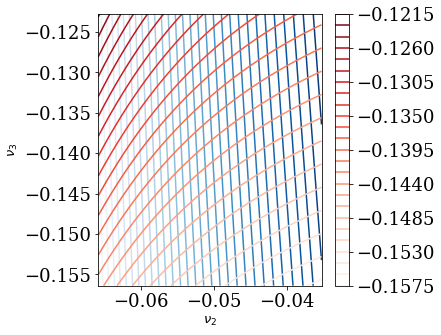

In [19]:
fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.contour(xx, yy, auto_enc_var_lev_set[:,1].reshape(n,n), 30, cmap='Blues')
plt.contour(xx, yy, auto_enc_var_lev_set[:,2].reshape(n,n), 30, cmap='Reds')
# ax.set_aspect('equal', adjustable='box')
ax.set_xlabel(r'$\nu_2$',fontsize =13);
ax.set_ylabel(r'$\nu_3$',fontsize =13)
plt.colorbar()

In [20]:
nu_3 = np.arange(np.min(auto_enc_var_lev_set[:,2]),np.max(auto_enc_var_lev_set[:,2]),0.0005)
nu_2 = np.arange(np.min(auto_enc_var_lev_set[:,1]),np.max(auto_enc_var_lev_set[:,1]),0.0005)

In [21]:
Points_sets_nu3 = []; Functions_sets_nu3 = [];
for i in range(nu_3.shape[0]-1):
  Intermediate = auto_enc_var_lev_set[:,2][nu_3[i]<=auto_enc_var_lev_set[:,2]]
  Functions_sets_nu3.append(Intermediate[nu_3[i+1]>=Intermediate])
  Intermediate_Points = Parameters_real[nu_3[i]<=auto_enc_var_lev_set[:,2]]
  Points_sets_nu3.append(Intermediate_Points[nu_3[i+1]>=Intermediate])

In [22]:
Points_sets_nu2 = []; Functions_sets_nu2 = [];
for i in range(nu_2.shape[0]-1):
  Intermediate = auto_enc_var_lev_set[:,1][nu_2[i]<=auto_enc_var_lev_set[:,1]]
  Functions_sets_nu2.append(Intermediate[nu_2[i+1]>=Intermediate])
  Intermediate_Points = Parameters_real[nu_2[i]<=auto_enc_var_lev_set[:,1]]
  Points_sets_nu2.append(Intermediate_Points[nu_2[i+1]>=Intermediate])

In [23]:
new_max = np.array([1.77879e+00 ,1.15000e+04 ,6.50000e+03])
new_min = np.array([9.32152e-01 ,6.90020e+03 ,3.90010e+03])

old_max = np.max(Parameters,axis=0)
old_min = np.min(Parameters,axis=0)

In [24]:
Matrix_points_nu2 = np.zeros((1,3))
for i in range(nu_2.shape[0]-1):
  if i % 5 == 0:
    Matrix_points_nu2 = np.r_[Matrix_points_nu2 ,Points_sets_nu2[i]]
Matrix_points_nu2 = Matrix_points_nu2[1:,:]
print(Matrix_points_nu2.shape)

Matrix_points_nu3 = np.zeros((1,3))
for i in range(nu_3.shape[0]-1):
  if i % 5 == 0:
    Matrix_points_nu3 = np.r_[Matrix_points_nu3 ,Points_sets_nu3[i]]
Matrix_points_nu3 = Matrix_points_nu3[1:,:]
print(Matrix_points_nu3.shape)

(7909, 3)
(8024, 3)


In [25]:
New_Param = (Parameters - old_min)/(old_max - old_min)*(new_max - new_min) +new_min
New_Param_nu2 = (Matrix_points_nu2 - old_min)/(old_max - old_min)*(new_max - new_min) +new_min
New_Param_nu3 = (Matrix_points_nu3 - old_min)/(old_max - old_min)*(new_max - new_min) +new_min

Text(0.5, 0.92, 'Colored with $\\nu_3$')

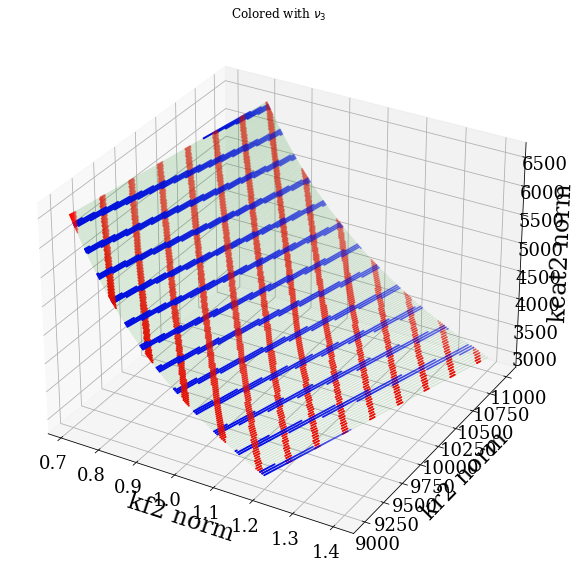

In [26]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(Parameters_real[:,0],Parameters_real[:,1],Parameters_real[:,2],s=0.1,c ='green',alpha=0.2)
for i in range(nu_2.shape[0]-1):
  if i % 5 == 0:
    ax.scatter3D(Points_sets_nu2[i][:,0],Points_sets_nu2[i][:,1],Points_sets_nu2[i][:,2],c='b',s=1)
for i in range(nu_3.shape[0]-1):
  if i % 5 == 0:
    ax.scatter3D(Points_sets_nu3[i][:,0],Points_sets_nu3[i][:,1],Points_sets_nu3[i][:,2],c='r',s=1)
ax.view_init(30, -60);

ax.set_xlabel('kf2 norm');ax.set_ylabel('kr2 norm');ax.set_zlabel('kcat2 norm')
ax.set_title('Colored with ' + r'$\nu_3$')

## Import the set of parameters that used for Figure 10 (First Row) 

In [27]:
Parameters = np.genfromtxt('Levelsets2_3.csv',delimiter=',');

In [28]:
Parameters = (Parameters - mean_param)/std_param

### Check that the sampled parameters are in the range of the training set

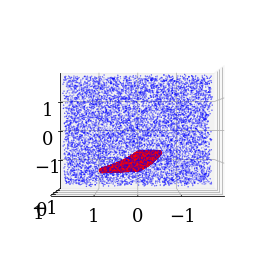

In [29]:
 fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(Parameters[:,0],Parameters[:,1],Parameters[:,2],c='r')
ax.scatter3D(*k_params_in.data.numpy().T,c = 'b',s=0.1)
ax.view_init(0, 90);

In [30]:
Param_red = Var(torch.from_numpy(Parameters))
Param_red.requires_grad=True

auto_enc_var_lev_set=encoder2(Param_red).data.numpy()

In [31]:
nu_3 = np.arange(np.min(auto_enc_var_lev_set[:,2]),np.max(auto_enc_var_lev_set[:,2]),0.0008)
nu_2 = np.arange(np.min(auto_enc_var_lev_set[:,1]),np.max(auto_enc_var_lev_set[:,1]),0.0005)

In [32]:
Points_sets_nu3 = []; Functions_sets_nu3 = [];
for i in range(nu_3.shape[0]-1):
  Intermediate = auto_enc_var_lev_set[:,2][nu_3[i]<=auto_enc_var_lev_set[:,2]]
  Functions_sets_nu3.append(Intermediate[nu_3[i+1]>=Intermediate])
  Intermediate_Points = Parameters[nu_3[i]<=auto_enc_var_lev_set[:,2]]
  Points_sets_nu3.append(Intermediate_Points[nu_3[i+1]>=Intermediate])


In [33]:
Points_sets_nu2 = []; Functions_sets_nu2 = [];
for i in range(nu_2.shape[0]-1):
  Intermediate = auto_enc_var_lev_set[:,1][nu_2[i]<=auto_enc_var_lev_set[:,1]]
  Functions_sets_nu2.append(Intermediate[nu_2[i+1]>=Intermediate])
  Intermediate_Points = Parameters[nu_2[i]<=auto_enc_var_lev_set[:,1]]
  Points_sets_nu2.append(Intermediate_Points[nu_2[i+1]>=Intermediate])


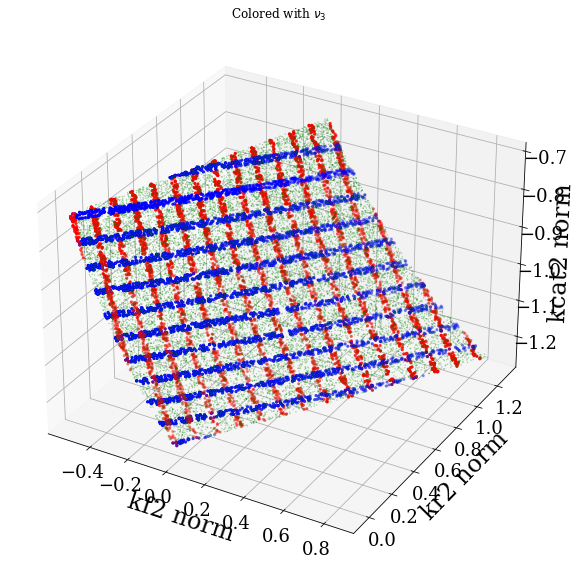

In [34]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(Parameters[:,0],Parameters[:,1],Parameters[:,2],s=0.1,c ='green',alpha=0.5)
for i in range(nu_2.shape[0]-1):
  if i % 4 == 0:
    ax.scatter3D(Points_sets_nu2[i][:,0],Points_sets_nu2[i][:,1],Points_sets_nu2[i][:,2],c='b',s=5)
for i in range(nu_3.shape[0]-1):
  if i % 4 == 0:
    ax.scatter3D(Points_sets_nu3[i][:,0],Points_sets_nu3[i][:,1],Points_sets_nu3[i][:,2],c='r',s=5)

ax.set_xlabel('kf2 norm');ax.set_ylabel('kr2 norm');ax.set_zlabel('kcat2 norm')
ax.set_title('Colored with ' + r'$\nu_3$')
sns.set_palette(sns.cubehelix_palette(10, start=2, rot=0, dark=0.05, light=0.85, reverse=False))
ax.view_init(30, -60);

In [35]:
xx,yy  = np.meshgrid(np.linspace(np.min(auto_enc_var_lev_set[:,1]),np.max(auto_enc_var_lev_set[:,1],0),100),
                    np.linspace(np.min(auto_enc_var_lev_set[:,1]),np.max(auto_enc_var_lev_set[:,1],0),n))

In [36]:
Matrix_points_nu2 = np.zeros((1,3))
Function_matrix_nu2 = np.zeros((1,))
Function_matrix_nu3 = np.zeros((1,))
for i in range(nu_2.shape[0]-1):
  if i % 3 == 0:
    Matrix_points_nu2 = np.r_[Matrix_points_nu2 ,Points_sets_nu2[i]]
    Function_matrix_nu2 = np.r_[Function_matrix_nu2,Functions_sets_nu2[i]]
Matrix_points_nu2 = Matrix_points_nu2[1:,:]
Function_matrix_nu2 = Function_matrix_nu2[1:]
print(Matrix_points_nu2.shape)

Matrix_points_nu3 = np.zeros((1,3))
for i in range(nu_3.shape[0]-1):
  if i % 4== 0:
    Matrix_points_nu3 = np.r_[Matrix_points_nu3 ,Points_sets_nu3[i]]
    Function_matrix_nu3 = np.r_[Function_matrix_nu3,Functions_sets_nu3[i]]
Matrix_points_nu3 = Matrix_points_nu3[1:,:]
Function_matrix_nu3 = Function_matrix_nu3[1:]
print(Matrix_points_nu3.shape)

(6612, 3)
(4988, 3)


In [37]:
New_Param = Parameters*std_param +mean_param
New_Param_nu2 = Matrix_points_nu2*std_param +mean_param
New_Param_nu3 = Matrix_points_nu3*std_param +mean_param

## Import the boundary for the level set (this was obtained by the edge function from matlab)

In [38]:
Indices = np.genfromtxt('Levelsets2_indices_3.csv',delimiter=',')
Indices.shape

Indices = Indices - 1;
Indices = Indices.astype(int)

(0.6, 1.9)

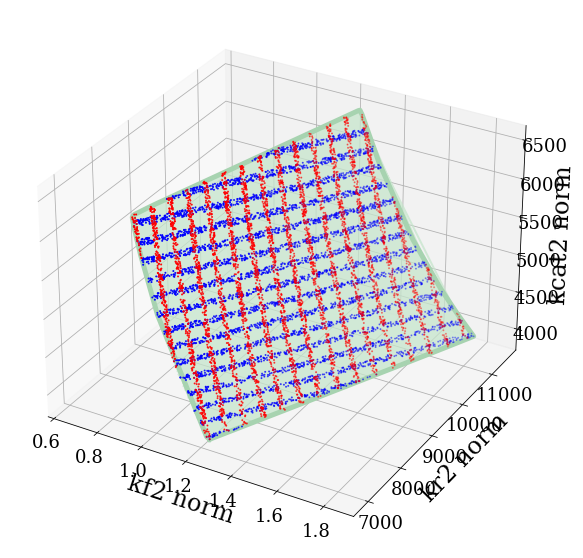

In [39]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')
ax.plot(New_Param[:,0]*1.3,New_Param[:,1],New_Param[:,2],linewidth =2,alpha=0.75)
ax.plot(New_Param[Indices,0]*1.3,New_Param[Indices,1],New_Param[Indices,2],linewidth =5)
ax.scatter3D(New_Param_nu3[:,0]*1.3,New_Param_nu3[:,1],New_Param_nu3[:,2],c='r',s=1)
ax.scatter3D(New_Param_nu2[:,0]*1.3,New_Param_nu2[:,1],New_Param_nu2[:,2],c='b',s=1)
ax.set_xlabel('kf2 norm');ax.set_ylabel('kr2 norm');ax.set_zlabel('kcat2 norm')
sns.set_palette(sns.cubehelix_palette(2, start=5, rot=0, dark=0.85, light=.95, reverse=False))
ax.view_init(30, -60);
ax.set_xlim(0.6,1.9)


In [40]:
Max_Nu = np.max(Parameters,axis =0)
Min_Nu= np.min(Parameters,axis =0)

Max_Nu = Var(torch.from_numpy(Max_Nu))
Max_Nu.requires_grad=True

Max_Nu = encoder2(Max_Nu).data.numpy()


Min_Nu = Var(torch.from_numpy(Min_Nu))
Min_Nu.requires_grad=True

Min_Nu = encoder2(Min_Nu).data.numpy()

(0.6, 1.9)

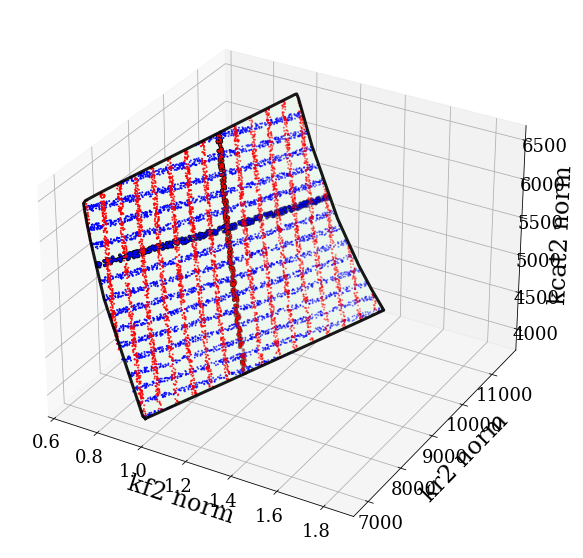

In [41]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(New_Param_nu3[:,0],New_Param_nu3[:,1],New_Param_nu3[:,2],c='r',s=1,zorder =-3)
ax.scatter3D((Points_sets_nu3[32][:,0]*std_param[0] +mean_param[0]),
             Points_sets_nu3[32][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu3[32][:,2]*std_param[2] +mean_param[2],c='r',
             s=8,edgecolor ='k',linewidth =1)


ax.scatter3D(New_Param_nu2[:,0],New_Param_nu2[:,1],New_Param_nu2[:,2],c='b',s=1,zorder =-3)
ax.scatter3D((Points_sets_nu2[30][:,0]*std_param[0] +mean_param[0]),
             Points_sets_nu2[30][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu2[30][:,2]*std_param[2] +mean_param[2],c='b',
             s=8,edgecolor ='k',linewidth =1)

ax.plot(New_Param[:,0],New_Param[:,1],New_Param[:,2],linewidth =1,alpha=1,zorder = -3)
ax.plot(New_Param[Indices,0],New_Param[Indices,1],New_Param[Indices,2],c='k',linewidth =3,zorder = 10,alpha=0.9)

ax.set_xlabel('kf2 norm');ax.set_ylabel('kr2 norm');ax.set_zlabel('kcat2 norm')
ax.view_init(30, -60);
sns.set_palette(sns.cubehelix_palette(2, start=5, rot=0, dark=0.60, light=.95, reverse=False))
ax.set_xlim(0.6,1.9)


In [42]:
A =Points_sets_nu2[30][np.argmin(Points_sets_nu2[30][:,1])]
A = Var(torch.from_numpy(A));A.requires_grad=True;A = encoder2(A).data.numpy()

B=Points_sets_nu2[30][np.argmax(Points_sets_nu2[30][:,1])]
B = Var(torch.from_numpy(B));B.requires_grad=True;B = encoder2(B).data.numpy()


In [43]:
# Produce the level set with constant nu2
nu_1_lin1,nu_3_lin1 = np.meshgrid(np.linspace(Min_Nu[0],Max_Nu[0],70),np.linspace(Min_Nu[-1]+0.001,Max_Nu[-1]-0.006,200))
nu_1_lin1,nu_3_lin1 = nu_1_lin1.flatten() ,nu_3_lin1.flatten()
nu_2_lin1 = np.ones_like(nu_1_lin1)*np.mean(Functions_sets_nu2[30])

Nus_lin1 = np.c_[nu_1_lin1,nu_2_lin1,nu_3_lin1]

Nus_lin1 = Var(torch.from_numpy(Nus_lin1))
Nus_lin1.requires_grad=True

Parameters_lin1 = decoder2(Nus_lin1).data.numpy()

In [44]:
# k_params_in = Var(torch.from_numpy(k_params_in))
# k_params_in.requires_grad=True
print('MIN NUs',np.min(encoder2(k_params_in).data.numpy(),axis=0))
print('MAX NUs',np.max(encoder2(k_params_in).data.numpy(),axis=0))

MIN NUs [-0.63337638 -0.12554061 -0.24885756]
MAX NUs [-0.12573241  0.02596409 -0.09722651]


Text(0.5, 0, 'kcat2 ')

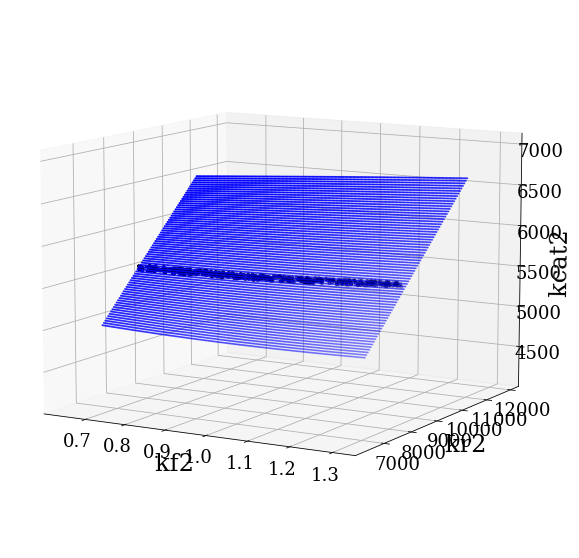

In [45]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')
Parameters_lin1_norm = Parameters_lin1*std_param + mean_param
ax.scatter(*Parameters_lin1_norm.T,c='b',s=1)
ax.scatter3D((Points_sets_nu2[30][:,0]*std_param[0] +mean_param[0]),
             Points_sets_nu2[30][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu2[30][:,2]*std_param[2] +mean_param[2],c='b',
             s=8,edgecolor ='k',linewidth =1)

ax.view_init(10, -60);

ax.set_xlabel('kf2 ');ax.set_ylabel('kr2 ');ax.set_zlabel('kcat2 ')

In [46]:
A =Points_sets_nu3[32][np.argmin(Points_sets_nu3[32],axis=0)]
A =np.min(Points_sets_nu3[32],axis=0)
A = Var(torch.from_numpy(A));A.requires_grad=True;A = encoder2(A).data.numpy()

B=Points_sets_nu3[32][np.argmax(Points_sets_nu3[32],axis=0)]
B =np.max(Points_sets_nu3[32],axis=0)
B = Var(torch.from_numpy(B));B.requires_grad=True;B = encoder2(B).data.numpy()
print(A,B)

[-0.24305308 -0.05379602 -0.15405743] [-0.30808855 -0.04585823 -0.14011317]


In [47]:
# Produce the level set with constant nu3
# nu_1_lin2,nu_2_lin2 = np.meshgrid(np.linspace(A[0],Max_Nu[0],70),np.linspace(A[1],Max_Nu[1],70))

nu_1_lin2,nu_2_lin2 = np.meshgrid(np.linspace(A[0],B[0],70),np.linspace(A[1]/1.37,B[1]*1.33,200))

nu_1_lin2,nu_2_lin2 = nu_1_lin2.flatten() ,nu_2_lin2.flatten()
nu_3_lin2 = np.ones_like(nu_1_lin2)*np.mean(Functions_sets_nu3[32])

Nus_lin2 = np.c_[nu_1_lin2,nu_2_lin2,nu_3_lin2]

Nus_lin2 = Var(torch.from_numpy(Nus_lin2))
Nus_lin2.requires_grad=True

Parameters_lin2 = decoder2(Nus_lin2).data.numpy()

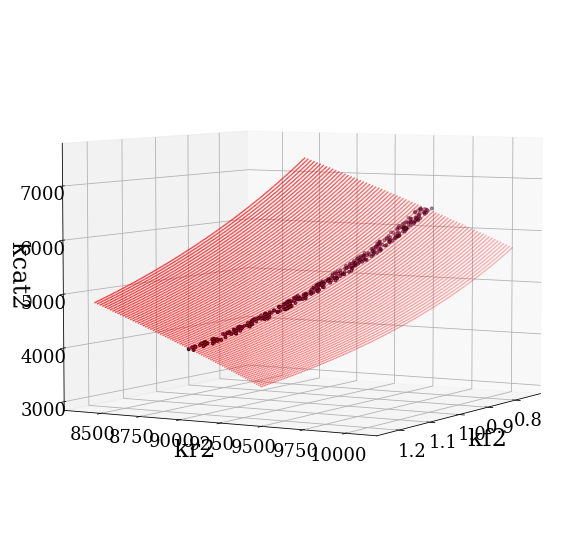

In [48]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')
Parameters_lin2_norm = Parameters_lin2*std_param + mean_param

ax.scatter3D((Points_sets_nu3[32][:,0]*std_param[0] +mean_param[0]),
             Points_sets_nu3[32][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu3[32][:,2]*std_param[2] +mean_param[2],c='purple',
             s=8,edgecolor ='k',linewidth =1)
ax.scatter3D(*Parameters_lin2_norm.T,c='r',s=0.2)

ax.set_xlabel('kf2 ');ax.set_ylabel('kr2 ');ax.set_zlabel('kcat2 ')

ax.view_init(5, 30);


(3500.0, 7200.0)

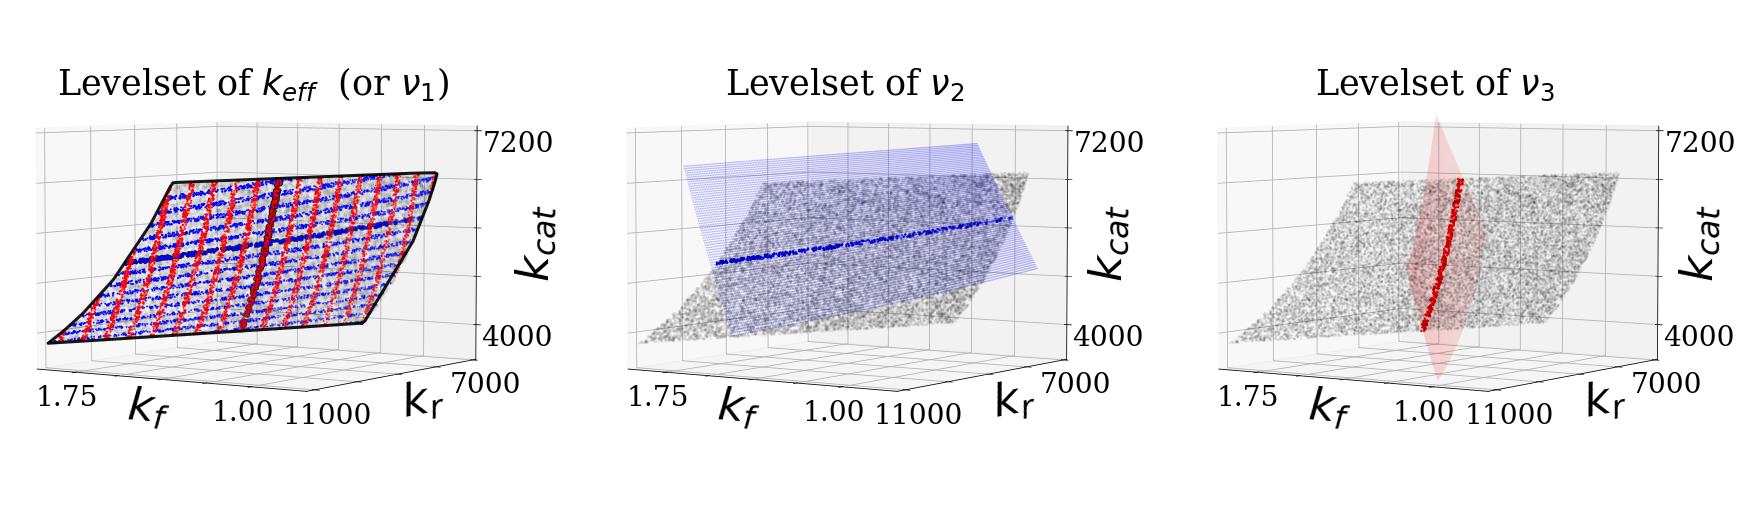

In [49]:
%matplotlib inline
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=30)
plt.rc('font', family='serif')
plt.rc('font', family='serif')


angle1 = 4;  angle2= 124;
n =45;
fig = plt.figure(figsize =(3*10,10))
ax = fig.add_subplot(131,projection='3d')
ax.scatter3D(New_Param_nu3[:,0]*1.32,New_Param_nu3[:,1],New_Param_nu3[:,2],c='r',s=1,zorder =-3)
ax.scatter3D((Points_sets_nu3[32][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu3[32][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu3[32][:,2]*std_param[2] +mean_param[2],c='r',
             s=8,edgecolor ='k',linewidth =1)
ax.scatter3D(New_Param_nu2[:,0]*1.32,New_Param_nu2[:,1],New_Param_nu2[:,2],c='b',s=1,zorder =-3)
ax.scatter3D((Points_sets_nu2[30][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu2[30][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu2[30][:,2]*std_param[2] +mean_param[2],c='b',
             s=8,edgecolor ='k',linewidth =0.5)
ax.plot(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],'k.',linewidth =0.1,alpha=0.02,zorder = -3)
ax.plot(New_Param[Indices,0]*1.32,New_Param[Indices,1],New_Param[Indices,2],c='k',linewidth =3,zorder = 10,alpha=0.9)
ax.set_xlabel(r'$k_{f}$',fontsize=n);ax.set_ylabel(r'$k_{r}$',fontsize=n);ax.set_zlabel(r'$k_{cat}$',fontsize=n)
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)

minor_ticks = np.linspace(1, 1.75, 5);ax.set_xticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_xticks(np.array([1,1.75]));

minor_ticks = np.linspace(7000, 11000, 5);ax.set_yticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_yticks(np.array([7000,11000]));


minor_ticks = np.linspace(4000, 7200, 5);ax.set_zticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_zticks(np.array([4000,7200]));
ax.set_title('Levelset of ' +  r'$k_{eff}$ ' + ' (or ' + r'$\nu_1$' + ')',fontsize =35,y=0.88)
ax.tick_params(axis="z",direction="out", pad=17)

ax.zaxis.labelpad = 15
ax.view_init(angle1, angle2);



ax = fig.add_subplot(132,projection='3d')
Parameters_lin1_norm = Parameters_lin1*std_param + mean_param
#ax.plot(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],'.k',linewidth =1,alpha=0.05)
ax.scatter3D((Points_sets_nu2[30][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu2[30][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu2[30][:,2]*std_param[2] +mean_param[2],c='b',
             s=2,edgecolor ='b',linewidth =1)
ax.scatter3D(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],c = 'k',alpha=0.05,s=4,zorder=2)
ax.scatter3D(Parameters_lin1_norm[:,0]*1.32,Parameters_lin1_norm[:,1],
             Parameters_lin1_norm[:,2],c='b',s=0.3,alpha=0.25,zorder=3)
ax.set_title('Levelset of ' +  r'$\nu_2$',fontsize =35,y=0.88)

ax.set_xlabel(r'$k_{f}$',fontsize=n);ax.set_ylabel(r'$k_{r}$',fontsize=n);ax.set_zlabel(r'$k_{cat}$',fontsize=n)
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)

minor_ticks = np.linspace(1, 1.75, 5);ax.set_xticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_xticks(np.array([1,1.75]));

minor_ticks = np.linspace(7000, 11000, 5);ax.set_yticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_yticks(np.array([7000,11000]));


minor_ticks = np.linspace(4000, 7200, 5);ax.set_zticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_zticks(np.array([4000,7200]));
ax.tick_params(axis="z",direction="out", pad=17)
ax.view_init(angle1, angle2);
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)


ax = fig.add_subplot(133,projection='3d')
# ax.scatter3D(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],c = 'k',alpha=0.1,s=1,zorder=2)
# ax.scatter3D(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],c = 'k',alpha=0.1,s=1,zorder=2)
ax.scatter3D((Points_sets_nu3[32][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu3[32][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu3[32][:,2]*std_param[2] +mean_param[2],c='r',
             s=2,edgecolor ='r',linewidth =1,alpha=1)
ax.scatter3D(Parameters_lin2_norm[:,0]*1.32,Parameters_lin2_norm[:,1],
             Parameters_lin2_norm[:,2],c='r',s=0.1,zorder=1,alpha=0.1)
ax.scatter3D(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],c = 'k',alpha=0.05,s=3,zorder=2)
ax.set_title('Levelset of ' +  r'$\nu_3$',fontsize =35,y=0.88)
ax.set_xlabel(r'$k_{f}$',fontsize=n);ax.set_ylabel(r'$k_{r}$',fontsize=n);ax.set_zlabel(r'$k_{cat}$',fontsize=n)
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)

minor_ticks = np.linspace(1, 1.75, 5);ax.set_xticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_xticks(np.array([1,1.75]));

minor_ticks = np.linspace(7000, 11000, 5);ax.set_yticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_yticks(np.array([7000,11000]));


minor_ticks = np.linspace(4000, 7200, 5);ax.set_zticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_zticks(np.array([4000,7200]));
# ax.set_title('Levelset of ' +  r'$k_{eff,2}$ ' + ' (or ' + r'$\nu_1$' + ')',fontsize =17)
ax.tick_params(axis="z",direction="out", pad=17)
ax.view_init(angle1, angle2);
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)




(3500.0, 7200.0)

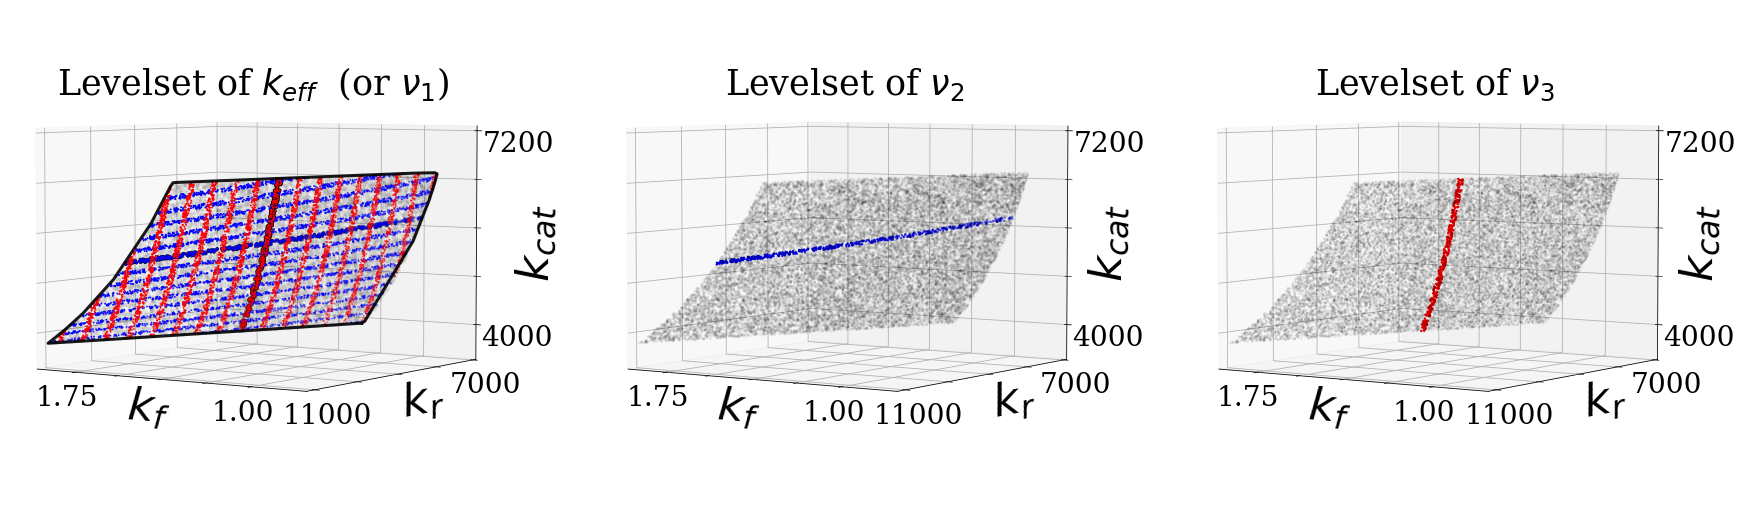

In [50]:
%matplotlib inline
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=30)
plt.rc('font', family='serif')
plt.rc('font', family='serif')


angle1 = 4;  angle2= 124;
n =45;
fig = plt.figure(figsize =(3*10,10))
ax = fig.add_subplot(131,projection='3d')
ax.scatter3D(New_Param_nu3[:,0]*1.32,New_Param_nu3[:,1],New_Param_nu3[:,2],c='r',s=1,zorder =-3)
ax.scatter3D((Points_sets_nu3[32][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu3[32][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu3[32][:,2]*std_param[2] +mean_param[2],c='r',
             s=8,edgecolor ='k',linewidth =1)
ax.scatter3D(New_Param_nu2[:,0]*1.32,New_Param_nu2[:,1],New_Param_nu2[:,2],c='b',s=1,zorder =-3)
ax.scatter3D((Points_sets_nu2[30][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu2[30][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu2[30][:,2]*std_param[2] +mean_param[2],c='b',
             s=8,edgecolor ='k',linewidth =0.5)
ax.plot(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],'k.',linewidth =0.1,alpha=0.02,zorder = -3)
ax.plot(New_Param[Indices,0]*1.32,New_Param[Indices,1],New_Param[Indices,2],c='k',linewidth =3,zorder = 10,alpha=0.9)
ax.set_xlabel(r'$k_{f}$',fontsize=n);ax.set_ylabel(r'$k_{r}$',fontsize=n);ax.set_zlabel(r'$k_{cat}$',fontsize=n)
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)

minor_ticks = np.linspace(1, 1.75, 5);ax.set_xticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_xticks(np.array([1,1.75]));

minor_ticks = np.linspace(7000, 11000, 5);ax.set_yticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_yticks(np.array([7000,11000]));


minor_ticks = np.linspace(4000, 7200, 5);ax.set_zticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_zticks(np.array([4000,7200]));
ax.set_title('Levelset of ' +  r'$k_{eff}$ ' + ' (or ' + r'$\nu_1$' + ')',fontsize =35,y=0.88)
ax.tick_params(axis="z",direction="out", pad=17)

ax.zaxis.labelpad = 15
ax.view_init(angle1, angle2);



ax = fig.add_subplot(132,projection='3d')
Parameters_lin1_norm = Parameters_lin1*std_param + mean_param
ax.scatter3D((Points_sets_nu2[30][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu2[30][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu2[30][:,2]*std_param[2] +mean_param[2],c='b',
             s=2,edgecolor ='b',linewidth =1)
ax.scatter3D(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],c = 'k',alpha=0.05,s=4,zorder=2)
ax.set_title('Levelset of ' +  r'$\nu_2$',fontsize =35,y=0.88)

ax.set_xlabel(r'$k_{f}$',fontsize=n);ax.set_ylabel(r'$k_{r}$',fontsize=n);ax.set_zlabel(r'$k_{cat}$',fontsize=n)
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)

minor_ticks = np.linspace(1, 1.75, 5);ax.set_xticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_xticks(np.array([1,1.75]));

minor_ticks = np.linspace(7000, 11000, 5);ax.set_yticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_yticks(np.array([7000,11000]));


minor_ticks = np.linspace(4000, 7200, 5);ax.set_zticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_zticks(np.array([4000,7200]));
ax.tick_params(axis="z",direction="out", pad=17)
ax.view_init(angle1, angle2);
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)


ax = fig.add_subplot(133,projection='3d')
ax.scatter3D((Points_sets_nu3[32][:,0]*std_param[0] +mean_param[0])*1.32,
             Points_sets_nu3[32][:,1]*std_param[1] +mean_param[1],
             Points_sets_nu3[32][:,2]*std_param[2] +mean_param[2],c='r',
             s=2,edgecolor ='r',linewidth =1,alpha=1)
ax.scatter3D(New_Param[:,0]*1.32,New_Param[:,1],New_Param[:,2],c = 'k',alpha=0.05,s=3,zorder=2)
ax.set_title('Levelset of ' +  r'$\nu_3$',fontsize =35,y=0.88)
ax.set_xlabel(r'$k_{f}$',fontsize=n);ax.set_ylabel(r'$k_{r}$',fontsize=n);ax.set_zlabel(r'$k_{cat}$',fontsize=n)
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)
minor_ticks = np.linspace(1, 1.75, 5);ax.set_xticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_xticks(np.array([1,1.75]));

minor_ticks = np.linspace(7000, 11000, 5);ax.set_yticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_yticks(np.array([7000,11000]));


minor_ticks = np.linspace(4000, 7200, 5);ax.set_zticks(minor_ticks, minor=True);ax.grid(which='both')
ax.set_zticks(np.array([4000,7200]));
ax.tick_params(axis="z",direction="out", pad=17)
ax.view_init(angle1, angle2);
ax.set_xlim(0.8,1.9);ax.set_ylim(7000,11100);ax.set_zlim(3500,7200)


